In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import avg, split, udf,count,sum,mean,round,col,max,min,lit
from pyspark.sql.types import IntegerType,DoubleType
from pyspark.ml.stat import Correlation

from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,GBTClassifier,NaiveBayes
import ibmos2spark
# @hidden_cell

cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-n3mm1l5ansd2bd'))
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
print("Number of rows before deleting NA :"+ str(df.dropna(how = "any", subset = ["userId", "sessionId"]).count()))
print("Number of rows after deleting NA :"+ str(df.count()))

Number of rows before deleting NA :543705
Number of rows after deleting NA :543705


In [5]:
def clean_data(df):
    
    """
    Input
    df: the dataframe to clean
    
    Output
    df: A clean dataframe with no nan userId and '' userId
    
    """
    
    df=df.dropna(how = "any", subset = ["userId", "sessionId"]).filter(df.userId!='')
    return df

df=clean_data(df)
print("Number of rows after cleaning :"+ str(df.count()))

Number of rows after cleaning :528005


In [6]:
df.select(df.page).dropDuplicates().sort(["page"]).show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [7]:
def churning(df):
    
    """
    Input
    df: the dataframe to add the churn column
    
    Output
    df: A dataframe with churn column
    
    """
    
    churned_user=[x.userId for x in df.filter(df.page=="Cancellation Confirmation").select('userId').dropDuplicates().collect()]
    return df.withColumn("churn",df.userId.isin(churned_user).cast("Integer"))

df =churning(df)

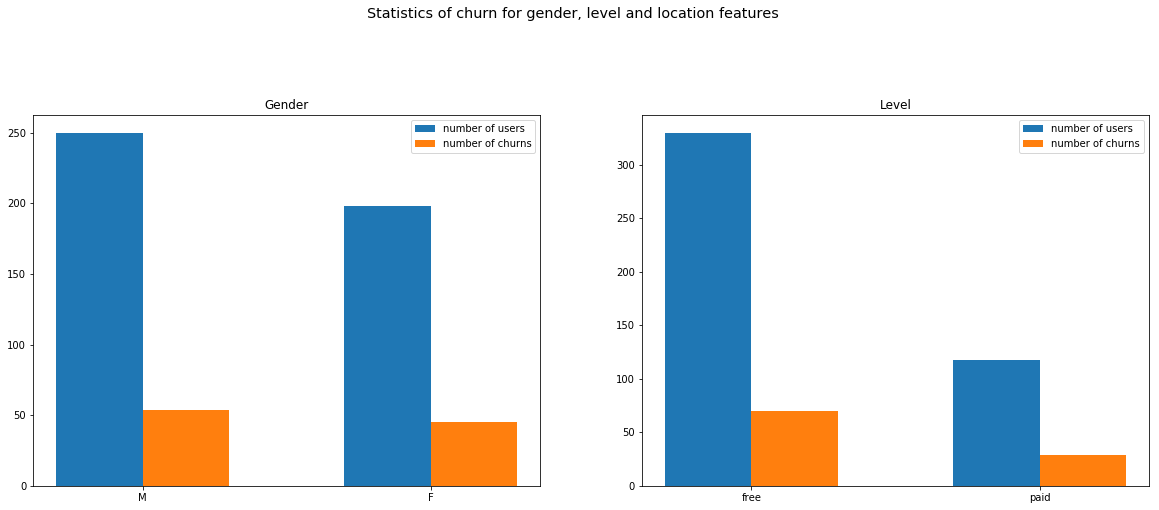

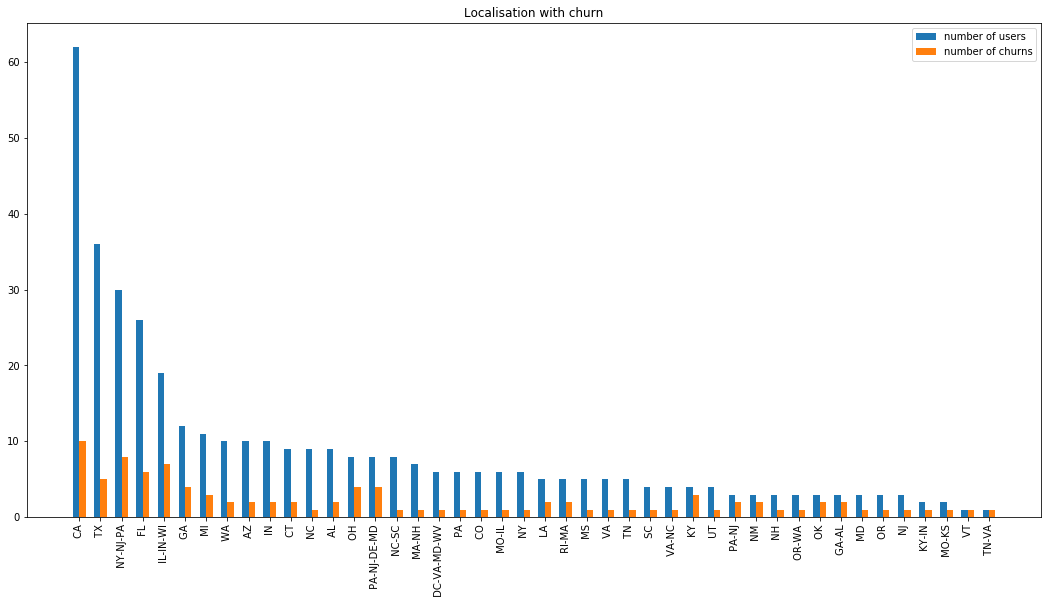

In [8]:
df=df.withColumn("location_level1",split(col("location"),",").getItem(1))
col_to_explore=['userId','gender','level','location_level1','churn']
df_explore=df.sort('ts').select(col_to_explore).dropDuplicates(subset=['userId'])
df_explore_gender=df_explore.groupby("gender").agg(sum('churn').alias('number of churns'),count('userId').alias('number of users')).sort(col('number of users').desc()).toPandas()
df_explore_level=df_explore.groupby("level").agg(sum('churn').alias('number of churns'),count('userId').alias('number of users')).sort(col('number of users').desc()).toPandas()
df_explore_location=df_explore.groupby("location_level1").agg(sum('churn').alias('number of churns'),count('userId').alias('number of users')).sort(col('number of users').desc()).toPandas()
df_explore_location=df_explore_location[df_explore_location['number of churns']>0]
fig = plt.figure(figsize=(20, 15))
fig.suptitle("Statistics of churn for gender, level and location features", fontsize="x-large")

width = 0.3

ax = fig.add_subplot(221)
x1 = np.arange(0, df_explore_gender.shape[0])
x2 = np.arange(0, df_explore_gender.shape[0])

ser1=ax.bar(x1, df_explore_gender['number of users'].values, width,tick_label = df_explore_gender["gender"].values)
ser2=ax.bar(x2 + width, df_explore_gender['number of churns'].values, width,tick_label = df_explore_gender["gender"].values)
ax.set_title('Gender')
ax.set_xticks(x1 + width / 2)
ax.legend((ser1[0], ser2[0]), ('number of users', 'number of churns'))

ax = fig.add_subplot(222)
x1 = np.arange(0, df_explore_level.shape[0])
x2 = np.arange(0, df_explore_level.shape[0])

ser1=ax.bar(x1, df_explore_level['number of users'].values, width,tick_label = df_explore_level["level"].values)
ser2=ax.bar(x2 + width, df_explore_level['number of churns'].values, width,tick_label = df_explore_level["level"].values)
ax.set_title('Level')
ax.set_xticks(x1 + width / 2)
ax.legend((ser1[0], ser2[0]), ('number of users', 'number of churns'))

fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(223)
x1 = np.arange(0, df_explore_location.shape[0])
x2 = np.arange(0, df_explore_location.shape[0])

ser1=ax.bar(x1, df_explore_location['number of users'].values, width,tick_label = df_explore_location["location_level1"].values)
ser2=ax.bar(x2 + width, df_explore_location['number of churns'].values, width,tick_label = df_explore_location["location_level1"].values)
ax.set_title('Localisation with churn')
ax.set_xticks(x1 + width / 2)
ax.legend((ser1[0], ser2[0]), ('number of users', 'number of churns'))

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [9]:
def feature_engineering(df):
    """
    input:
    df: the initial dataframe from which the features will be extracted
    output:
    df_user: cleansed data to use in the models
    """
    df=df.withColumn("location_level1",split(col("location"),",").getItem(1))
    df=df.sort('ts')
    get_duree = udf(lambda x: x / (3600*1000.0))
    get_localisation = udf(lambda x: 1 if x.replace(' ','')=='CA' else 0)
    wdw = Window.partitionBy("userId")
    df = df.withColumn('last_ts', max('ts').over(wdw))
    df = df.withColumn('first_ts', min('ts').over(wdw))
    df=df.withColumn("duree", get_duree(df.last_ts-df.first_ts).cast(DoubleType()))
    #feature 1 - user's information : gender, level and localisation
    df_user=df.sort('ts').select(['userId','churn','gender','level','location_level1','duree']).dropDuplicates(subset=['userId'])
    df_user=df_user.withColumn("isCA",get_localisation(df_user.location_level1).cast(IntegerType()))
    df_user=df_user.replace(["M", "F"], ["0", "1"], "gender")
    df_user=df_user.replace(["free", "paid"], ["0", "1"], "level")
    df_user=df_user.withColumn("gender",df_user.level.cast(IntegerType()))
    df_user=df_user.withColumn("level",df_user.level.cast(IntegerType()))
    #feature 2 - user's interactions
    # Average song played in one session and number of songs played
    df_user_inter=df.filter((df.page=='NextSong')) \
            .groupBy('userID','sessionId') \
            .agg(count('sessionId').alias('nb_song')) \
            .groupBy('userID') \
            .agg(round(mean('nb_song'),0).alias('average_nb_song'),sum('nb_song').alias('nb_song'))
    # average time  between sessions
    df_time_session=df.select('userID','sessionId','duree').dropDuplicates() \
            .groupBy('userID','duree') \
            .agg(count('sessionId').alias('number_of_session'))

    df_time_session=df_time_session.withColumn('avg_time_session',df_time_session.duree/df_time_session.number_of_session)
    # Tumps up/down and upvote/downvote
    df_user_inter_tUP=df.filter((df.page=='Thumbs Up')) \
            .groupBy('userID','sessionId') \
            .agg(count('sessionId').alias('step')) \
            .groupBy('userID') \
            .agg(round(mean('step'),0).alias('av_tumpup'))
    df_user_inter_tDOWN=df.filter((df.page=='Thumbs Down')) \
            .groupBy('userID','sessionId') \
            .agg(count('sessionId').alias('step')) \
            .groupBy('userID') \
            .agg(round(mean('step'),0).alias('av_tumpdown'))
    
    df_user = df_user.join(df_user_inter,'userId',how="outer")
    df_user = df_user.join(df_user_inter_tUP,'userId',how="outer")
    df_user = df_user.join(df_user_inter_tDOWN,'userId',how="outer")
    df_user = df_user.join(df_time_session.select('userID','avg_time_session'),'userId',how="outer")
    df_user=df_user[['churn','gender','level','isCA','average_nb_song','av_tumpup','av_tumpdown','duree','avg_time_session','nb_song']]
    df_user = df_user.withColumnRenamed("churn", "label")

    df_user=df_user.fillna({ 'av_tumpup':0, 'av_tumpdown':0 })
    return df_user

In [10]:
df_model=feature_engineering(df)
df_model.printSchema()

root
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- isCA: integer (nullable = true)
 |-- average_nb_song: double (nullable = true)
 |-- av_tumpup: double (nullable = false)
 |-- av_tumpdown: double (nullable = false)
 |-- duree: double (nullable = true)
 |-- avg_time_session: double (nullable = true)
 |-- nb_song: long (nullable = true)



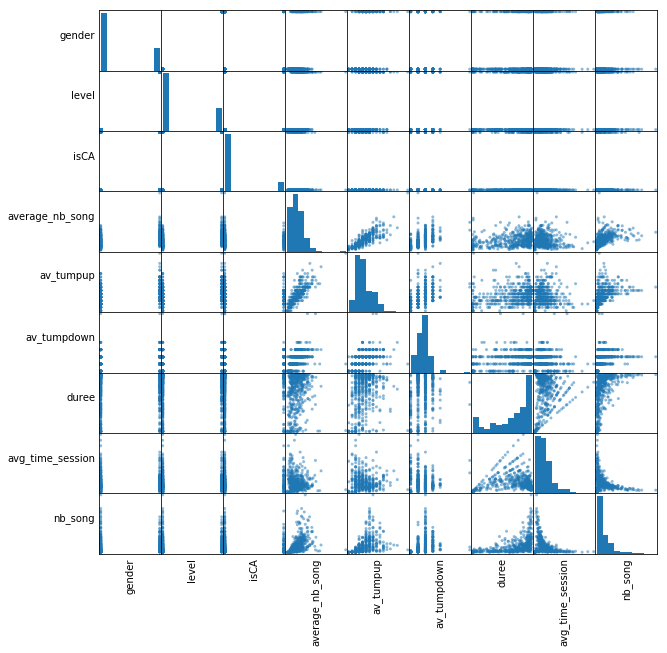

In [15]:
df_pds = df_model.toPandas()[df_model.columns[1:]]
axs = pd.plotting.scatter_matrix(df_pds, figsize=(10, 10));
n = len(df_pds.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [12]:
def train_models(df_model):
    """
    input:
    df_model: data to use for the modelling
    
    output
    trainned_model: dictionnary containing all the trainned model
    """
    
    #Splitting between train, test and validation
    df_model=feature_engineering(df)
    train, test_valid=df_model.randomSplit([0.7, 0.3], seed=42)
    test, valid=test_valid.randomSplit([0.5, 0.5], seed=42)
    assembler=VectorAssembler(inputCols=df_model.columns[1:],outputCol='features_int')
    scaler = StandardScaler(inputCol="features_int", outputCol="features", withStd=True)
    
    #Five model to test
    models={
        'Logistic Regression':LogisticRegression(maxIter=10),
        'Decission Tree Classifier':DecisionTreeClassifier(),
        'Random Forest Classifier':RandomForestClassifier(),
        'Gradient Boosted Tree':GBTClassifier(maxIter=10),
        'Naive Bayes':NaiveBayes()
    }
    
    #paramGrid for tuning
    paramGrid={
        'Logistic Regression':ParamGridBuilder() \
            .addGrid( models['Logistic Regression'].regParam, [0,0.01,0.001,0.0001]) \
            .addGrid(models['Logistic Regression'].family, ['binomial','multinomial']) \
            .build(),
        'Decission Tree Classifier':ParamGridBuilder()
             .addGrid(models['Decission Tree Classifier'].maxDepth, [2,  10, 30])
             .addGrid(models['Decission Tree Classifier'].maxBins, [10, 40, 100])
             .build(),
        'Random Forest Classifier': ParamGridBuilder() \
            .addGrid(models['Random Forest Classifier'].numTrees, [10, 30, 50]) \
            .addGrid(models['Random Forest Classifier'].maxDepth, [2, 10, 30]) \
            .build(),
        'Gradient Boosted Tree':ParamGridBuilder() \
            .addGrid(models['Gradient Boosted Tree'].maxBins, [10, 40, 100]) \
            .addGrid(models['Gradient Boosted Tree'].maxDepth, [2, 10, 30]) \
            .build(),
        'Naive Bayes':ParamGridBuilder() \
            .addGrid(models['Naive Bayes'].smoothing, [0.0,0.6,1.0])\
            .build()
    }
    
    trainned_model={}
    for mdl in models:
        print('Trainning model ' + mdl)
        print('...')
        pipeline = Pipeline(stages = [assembler,scaler, models[mdl]])
        crossval= CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid[mdl],
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)
        model_test = crossval.fit(train)
        
        trainned_model[mdl]=model_test
        evaluator = MulticlassClassificationEvaluator()
        pred_train=model_test.transform(train)
        pred_test=model_test.transform(test)
        pred_valid=model_test.transform(valid)
        print(mdl + ' metrics:')
        print('Train - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_train, {evaluator.metricName: "accuracy"}),100*evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})))
        print('Test  - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_test, {evaluator.metricName: "accuracy"}),100*evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})))
        print('Valid - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_valid, {evaluator.metricName: "accuracy"}),100*evaluator.evaluate(pred_valid, {evaluator.metricName: "f1"})))
        
    return trainned_model

In [13]:
trainned_model=train_models(df_model)

Trainning model Logistic Regression
...
Logistic Regression metrics:
Train - Accuracy: 84.18% and F-1 Score: 82.71%
Test  - Accuracy: 78.12% and F-1 Score: 80.44%
Valid - Accuracy: 84.00% and F-1 Score: 82.81%
Trainning model Decission Tree Classifier
...
Decission Tree Classifier metrics:
Train - Accuracy: 87.66% and F-1 Score: 87.25%
Test  - Accuracy: 84.38% and F-1 Score: 81.25%
Valid - Accuracy: 84.00% and F-1 Score: 84.00%
Trainning model Random Forest Classifier
...
Random Forest Classifier metrics:
Train - Accuracy: 98.10% and F-1 Score: 98.09%
Test  - Accuracy: 87.50% and F-1 Score: 84.26%
Valid - Accuracy: 87.00% and F-1 Score: 86.53%
Trainning model Gradient Boosted Tree
...
Gradient Boosted Tree metrics:
Train - Accuracy: 90.19% and F-1 Score: 89.64%
Test  - Accuracy: 81.25% and F-1 Score: 81.25%
Valid - Accuracy: 87.00% and F-1 Score: 87.38%
Trainning model Naive Bayes
...
Naive Bayes metrics:
Train - Accuracy: 79.75% and F-1 Score: 73.28%
Test  - Accuracy: 65.62% and F-1 S